In [2]:
class TechnologieWissen:
    def __init__(self, name: str, letzte_verwendung: int):
        self.name = name
        self.letzte_verwendung = letzte_verwendung

    def __repr__(self):
        return f"{self.name}: vor {self.letzte_verwendung} Tagen"

class MitarbeiterSkills:
    def __init__(self, name: str, technologien: list[TechnologieWissen]):
        self.name = name
        self.technologien = technologien

    def __repr__(self):
        technologien_str = "\n    ".join([repr(t) for t in self.technologien])
        return (
            f"Mitarbeiter:\n"
            f"  Name: {self.name}\n"
            f"  Skills:\n"
            f"    {technologien_str}"
        )
    
    def to_embedding(self):
        # Konvertiere die Technologien in eine Liste von Strings
        technologien_str = [t.name for t in self.technologien]
        # Erstelle ein Embedding aus den Technologien
        return " ".join(technologien_str)

In [3]:
import json
import random

with open("technologien.json", "r", encoding="utf-8") as f:
    technologien = json.load(f)
with open("namen.json", "r", encoding="utf-8") as f:
    namen = json.load(f)

def get_random_skills():
    skills = []
    for _ in range(1, random.randint(1, 5) + 1):
        tech_name = random.choice(technologien)
        skills.append(TechnologieWissen(tech_name, random.randint(0, 2 * 365)))
    return skills

## Formatieren der Daten

In [4]:
data: list[MitarbeiterSkills] = []

for name in namen:
    skills = get_random_skills()
    mitarbeiter = MitarbeiterSkills(name, skills)
    data.append(mitarbeiter)

for ma in data:
    print(ma)

Mitarbeiter:
  Name: Laura Müller
  Skills:
    Docker: vor 503 Tagen
    Google Cloud: vor 194 Tagen
Mitarbeiter:
  Name: Maximilian Schmidt
  Skills:
    AWS: vor 65 Tagen
    Go: vor 203 Tagen
    Ruby: vor 339 Tagen
    Rust: vor 449 Tagen
Mitarbeiter:
  Name: Anna Fischer
  Skills:
    Git: vor 701 Tagen
    JIRA: vor 374 Tagen
    NumPy: vor 308 Tagen
    Docker: vor 712 Tagen
    Flask: vor 704 Tagen
Mitarbeiter:
  Name: Jonas Wagner
  Skills:
    Flask: vor 303 Tagen
    Ansible: vor 273 Tagen
Mitarbeiter:
  Name: Sofia Hofmann
  Skills:
    Keras: vor 281 Tagen
    Go: vor 483 Tagen
Mitarbeiter:
  Name: Paul Klein
  Skills:
    Django: vor 684 Tagen
    Docker: vor 193 Tagen
    Express.js: vor 648 Tagen
Mitarbeiter:
  Name: Emma Lehmann
  Skills:
    PostgreSQL: vor 57 Tagen
    Power BI: vor 316 Tagen
Mitarbeiter:
  Name: Liam Becker
  Skills:
    Bitbucket: vor 216 Tagen
    Rust: vor 298 Tagen
    Angular: vor 294 Tagen
Mitarbeiter:
  Name: Mia Krüger
  Skills:
    Postgre

## Erstellen der Vektoren (Embeddings)

In [5]:
from openai import OpenAI

client = OpenAI()

def embedd(data):
    return client.embeddings.create(input=data, model="text-embedding-3-small").data[0].embedding

In [6]:
embedded_data = []

for ma in data:
    embedded_data.append(
        embedd(ma.to_embedding())
    )

## Erstellen der Vektordatenbank

In [7]:
import faiss
import numpy as np

dim = len(embedded_data[0])
index = faiss.IndexFlatL2(dim)

embeddings_np = np.array(embedded_data).astype("float32")
index.add(embeddings_np)

## Finden von Clustern mit KMeans

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings_np)

c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Suche in der Vektordatenbank

In [23]:
query = "Backend Technologien"
query_vector = client.embeddings.create(input=query, model="text-embedding-3-small").data[0].embedding

search_vector = np.array([query_vector]).astype('float32')

erg_anzahl = 5

D, indices = index.search(search_vector, erg_anzahl)

print(f"Distances: {D}")
print(f"Indices: {indices}")

for i in indices[0]:
    print(data[i])

Distances: [[1.3219886 1.3232605 1.3464255 1.3523738 1.3574529]]
Indices: [[ 99  15  39 127 218]]
Mitarbeiter:
  Name: Linda Voigt
  Skills:
    MySQL: vor 230 Tagen
    Confluence: vor 641 Tagen
    TensorFlow: vor 539 Tagen
    Jenkins: vor 84 Tagen
    Angular: vor 185 Tagen
Mitarbeiter:
  Name: Finn Neumann
  Skills:
    MySQL: vor 219 Tagen
Mitarbeiter:
  Name: Lena Richter
  Skills:
    Git: vor 635 Tagen
    JavaScript: vor 409 Tagen
Mitarbeiter:
  Name: Carla Pietsch
  Skills:
    React: vor 660 Tagen
    PHP: vor 137 Tagen
    Django: vor 304 Tagen
    Java: vor 565 Tagen
Mitarbeiter:
  Name: Dorothee Hermes
  Skills:
    Azure: vor 585 Tagen
    Confluence: vor 49 Tagen
    Tableau: vor 212 Tagen


## Darstellen mit t-SNE

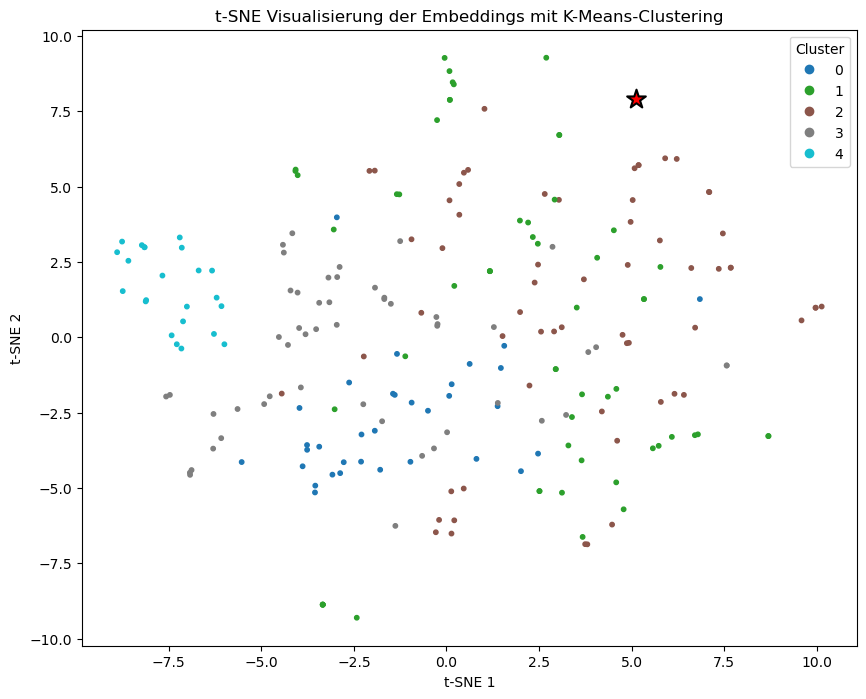

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Kombiniere Embeddings und Query-Vektor für t-SNE
all_embeddings = np.vstack([embeddings_np, search_vector])
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=300)
reduced_all = tsne.fit_transform(all_embeddings)
reduced_embeddings = reduced_all[:-1]
query_tsne = reduced_all[-1]

# Plotten der reduzierten Embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='tab10', s=10)
plt.scatter(query_tsne[0], query_tsne[1], s=200, c="red", marker="*", edgecolor="black", linewidths=1.5, label="Query-Vektor")

# Optional: Titel und Achsenbeschriftungen hinzufügen
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("t-SNE Visualisierung der Embeddings mit K-Means-Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()

